# Chroma-Multimodal

- Author: [Gwangwon Jung](https://github.com/pupba)
- Design: []()
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/09-VectorStore/02-Chroma-Multimodal.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/09-VectorStore/02-Chroma-Multimodal.ipynb)

## Overview

This tutorial covers how to use **Chroma Multimodal Vector Store** with **LangChain** .

In this tutorial, we will inherit the `ChromaDB` class from the previous tutorial to create a class that adds a **Multimodal** feature, and then use this class to implement an example of a **multimodal search** engine.

![search-example](./assets/02-chroma-with-langchain-flow-search-example.png)

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Multimodal Search](#multimodal-search)
- [Create a Multimodal Vector Store](#create-a-multimodal-vector-store)
- [Image Searching](#image-searching)
- [Multimodal Document Manager](#multimodal-document-manager)


### References

- [Chroma Docs](https://docs.trychroma.com/docs/overview/introduction)
- [Langchain-Chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma/)
- [List of VectorStore supported by Langchain](https://python.langchain.com/docs/integrations/vectorstores/)
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain-core",
        "langchain-chroma",
        "langchain-huggingface",
        "langchain-experimental",
        "chromadb",
        "pillow",
        "open_clip_torch",
        "scikit-learn",
        "numpy",
        "requests",
        "pydantic",
        "python-dotenv",
        "datasets >= 3.2.0",  # Requirements >= 3.2.0
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Chroma With Langchain",  # title 과 동일하게 설정해 주세요
        "HUGGINGFACEHUB_API_TOKEN": "",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Multimodal Search

**Chorma** supports **Multimodal Collections** , which means it can handle and store embeddings from different types of data, such as **text** , **images** , **audio** , or even **video** .

We can search for **images** using **Chroma** .

### Setting image and image_info data

This dataset is made by **SDXL** . 

**Dataset: Animal-180**

- [animal-180](https://huggingface.co/datasets/Pupba/animal-180)

This dataset, named `animal-180` , is a collection of 180 realistic animal images generated using **Stable-Diffusion XL(SDXL)** .

It includes images of **lions** , **rabbits** , **cats** , **dogs** , **elephants** and **tigers** , with 30 images per animal category.

All images are free to use for any purpose, as they are synthetically generated and not subject to copyright restrictions.

In [5]:
import tempfile
from PIL import Image


def save_temp_gen_url(image: Image) -> str:
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
    image.save(temp_file, format="PNG")
    temp_file.close()
    return temp_file.name

In [6]:
from datasets import load_dataset
import random

dataset = load_dataset("Pupba/animal-180", split="train")
dataset = dataset.shuffle()
# slice random 50 set
images = dataset["png"][:50]
image_paths = [save_temp_gen_url(img) for img in images]
metas = dataset["json"][:50]
prompts = [data["prompt"] for data in metas]
categories = [data["category"] for data in metas]

c:\Users\Jung\AppData\Local\pypoetry\Cache\virtualenvs\langchain-opentutorial-B290FrwJ-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using the latest cached version of the dataset since Pupba/animal-180 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\Jung\.cache\huggingface\datasets\Pupba___animal-180\default\0.0.0\f1aeaf95fdd67cbb218f545b3b0ef7fc53dbdc1d (last modified on Wed Feb 12 00:13:27 2025).


Image Path: C:\Users\Jung\AppData\Local\Temp\tmpnu33eb2u.png
Prompt: a cat lying on a soft blanket, surrounded by toys, warm lighting, photorealistic, 8k resolution.
Category: cat


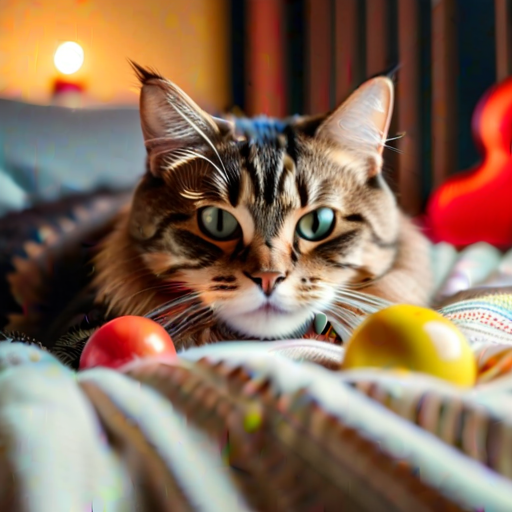

In [7]:
print("Image Path:", image_paths[0])
print("Prompt:", prompts[0])
print("Category:", categories[0])
images[0]

Load `OpenCLIP` for **Multimodal Embedding** .

- [OpenCLIP](https://github.com/mlfoundations/open_clip/tree/main)

In [10]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings

MODEL = "ViT-B-16-quickgelu"
CHECKPOINT = "openai"

multimodal_embedding = OpenCLIPEmbeddings(model_name=MODEL, checkpoint=CHECKPOINT)

## Create a Multimodal Vector Store

`ChromaDB` is a child class that inherits and defines `ChromaMultimodalDB` to add an image processing function.

Load `ImageMetadata` , `ImageDocumentChroma` and `ChromaMulitmodalDB` from **utils/chroma/multimodal.py** .

In [2]:
from utils.chroma.multimodal import (
    ImageMetadata,
    ImageDocumentChroma,
    ChromaMulitmodalDB,
)

In [3]:
vector_store = ChromaMulitmodalDB(embeddings=multimodal_embedding)

configs = {
    "mode": "persistent",
    "persistent_path": "data/chroma_mulitmodal",
    "collection": "test",
    "hnsw:space": "cosine",
}

vector_store.connect(**configs)

### Adding **Multimodal Data** to vector store.

Preprocess mutimodal data.

In [11]:
image_documents = vector_store.preprocess_image_documents(
    uris=image_paths, prompts=prompts, categories=categories
)
image_documents[0]

ImageDocumentChroma(id='24b08de3-781e-488d-af01-7fcccf3ab3a3', image_uri='C:\\Users\\Jung\\AppData\\Local\\Temp\\tmp9dt0pak8.png', metadata=ImageMetadata(category='rabbit', prompt='a fluffy white rabbit sitting in a grassy meadow, soft sunlight illuminating its fur, highly detailed, 8k resolution.'))

In [12]:
len(image_documents)

50

Adding `ImageDocumentChroma` data to vector store.

`add_images()` , the method of `LangChain-Chroma` , supports `upsert` by default.

In [13]:
ids = vector_store.add_images(image_documents=[image_documents[0]])
ids
vector_store.chroma.get(ids=ids)["ids"]

['24b08de3-781e-488d-af01-7fcccf3ab3a3']

Using `upsert_images_parallel()`

In [14]:
ids = vector_store.upsert_images_parallel(
    image_uri_documents=image_documents, batch_size=16, max_workers=4
)
len(ids)

50

## Image Searching

We can perform image retrieval in two ways.

- Text Query Search
- Image Query Search

### Text Query Search

Use Text query to search for images similar to those described by the text.

In [9]:
from IPython.display import display

In [10]:
def show_docs(results: list) -> None:
    for idx, (score, docs) in enumerate(results):
        print(f"Rank[{idx+1}]")
        print(f"Category: {docs.metadata.category}")
        print(f"Prompt: {docs.metadata.prompt}")
        print(f"Cosine Similarity Score: {score:.3f}")
        display(vector_store.toPIL(docs.image_uri))
        print()

Rank[1]
Category: elephant
Prompt: an elephant walking through tall grass, golden sunlight reflecting off its skin, highly detailed, natural lighting, ultra-realistic.
Cosine Similarity Score: 0.310


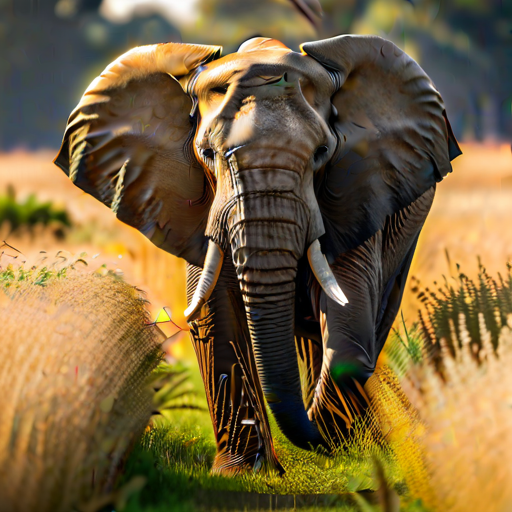


Rank[2]
Category: elephant
Prompt: an elephant roaring in the early morning light, mist in the background, highly detailed, ultra-realistic, 8k resolution.
Cosine Similarity Score: 0.308


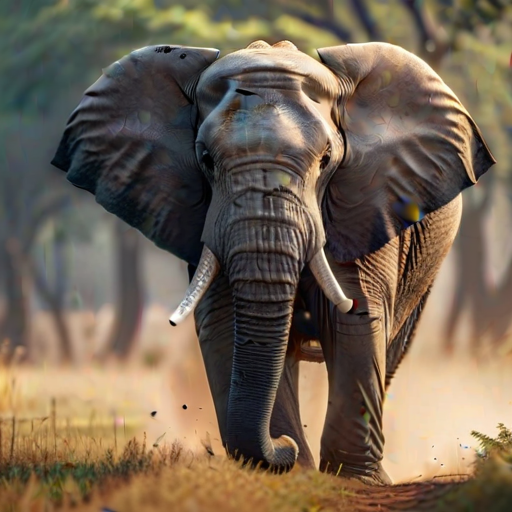

In [17]:
results = vector_store.searching_text_query(text_query="a elephant run", k=2)

show_docs(results)

### Image Query Search

Search for images that are similar to the images.

In [6]:
# query image url
import requests
import io


def load_image_from_url(url: str, resolution: int = 512) -> Image.Image:
    """
    Load an image from a URL and return it as a PIL Image object.

    Args:
        url (str): The URL of the image.

    Returns:
        Image.Image: The loaded PIL Image object.
    """
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for failed requests
    image = Image.open(io.BytesIO(response.content))
    image = image.resize((resolution, resolution), resample=Image.Resampling.LANCZOS)
    return image


def save_image_to_tempfile(url: str) -> str:
    """
    Download an image from a URL and save it to a temporary file.

    Args:
        url (str): The URL of the image.

    Returns:
        str: The file path to the saved image.
    """
    response = requests.get(url)

    # Raise an error for failed requests
    response.raise_for_status()

    # Create a temporary file
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".jpg")
    temp_file.write(response.content)

    # Close the file to allow other processes to access it
    temp_file.close()
    return temp_file.name

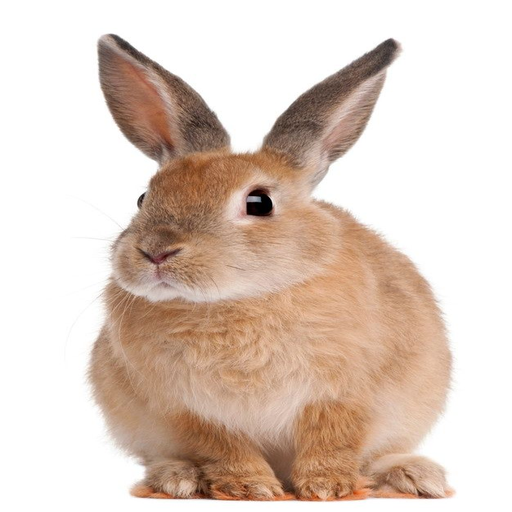

In [7]:
# rabbit image
img_url = "https://i.pinimg.com/736x/b2/e9/f4/b2e9f449c1c5f8a29e31cafb8671c8b2.jpg"

image_query = load_image_from_url(img_url)
image_query_url = save_image_to_tempfile(img_url)

image_query

Rank[1]
Category: rabbit
Prompt: a rabbit sitting on a stone wall, looking at the camera, soft natural lighting, highly detailed, ultra-realistic.
Cosine Similarity Score: 0.913


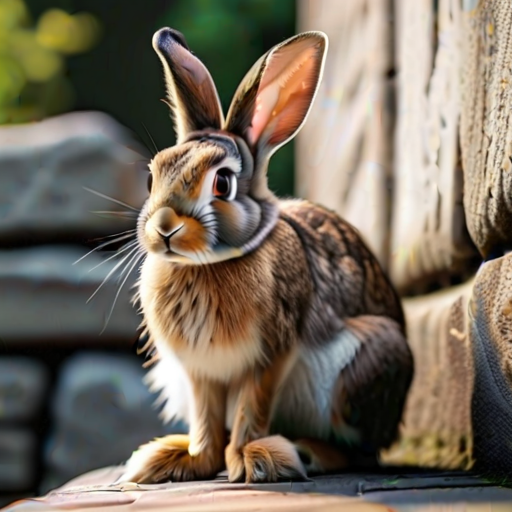


Rank[2]
Category: rabbit
Prompt: a rabbit standing on its hind legs, looking at the camera, soft golden lighting, highly detailed, 8k resolution.
Cosine Similarity Score: 0.885


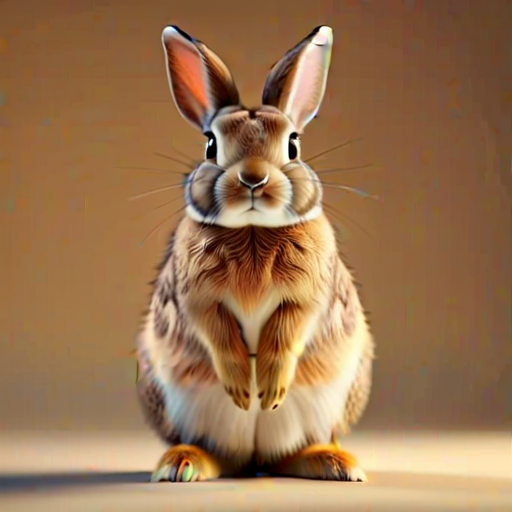

In [11]:
results = vector_store.search_image_query(
    image_uri=image_query_url, k=2, filters={"category": "rabbit"}
)

show_docs(results=results)

Disconnect `Chroma` DB and Remove Local DB file

In [15]:
del vector_store

## Multimodal Document Manager

We have developed an interface that makes **Image CRUD** of **VectorDB** easy to use in tutorials.

This class was implemented by inheriting `ChromaDocumentMangager` .

- `upsert` : Inserts or updates Image documents in the vector database with optional metadata and embeddings.

- `upsert_parellel` : Processes batch insertions or updates in parallel for improved performance.

- `search` : Searches for the top k most similar Image documents using **cosine similarity** (In this tutorial, we fix the similarity score as cosine similarity) .

- `delete` : Same as parent class

Each function was inherited and developed for each vector DB.

In this tutorial, it was developed for **Chroma** .

Load **Chroma Client** and **Multimodal Embedding** .

In [8]:
import chromadb

client = chromadb.PersistentClient(path="./chroma")

In [9]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings

MODEL = "ViT-B-16-quickgelu"
CHECKPOINT = "openai"

multimodal_embedding = OpenCLIPEmbeddings(model_name=MODEL, checkpoint=CHECKPOINT)

Load `ChromaDocumentMultuimoalManager` .

In [ ]:
from utils.chroma.multimodal_crud import ChromaMultimodalDocumentMangager

cdmm = ChromaMultimodalDocumentMangager(
    client=client, embedding=multimodal_embedding, name="chroma"
)  # Default open_clip

Preprocessing for `image_upsert` .

In [11]:
from uuid import uuid4

images
metas
ids = [str(uuid4()) for i in range(len(images))]

### Upsert

The upsert method is designed to **insert** or **update** documents in a vector database. 

It takes the following parameters:

- **images** : A collection of PIL.Image to be inserted or updated. PIL.Image change to base64 string.

- **metadatas** : Optional metadata associated with each document.

- **ids** : Optional unique identifiers for each document.

- ****kwargs** : Additional keyword arguments for flexibility.

In [12]:
cdmm.image_upsert(
    images=images[:2],
    metadatas=metas[:2],
    ids=ids[:2],
)

### Upsert-Parellel

The `image_upsert_parallel` method is an optimized version of `image_upsert` that processes documents in parallel.

The following parameters are added.

- **batch_size** : The number of documents to process in each batch (default: 32).

- **workers** : The number of parallel workers to use (default: 10).

In [13]:
cdmm.image_upsert_parallel(
    images=images[2:10],
    metadatas=metas[2:10],
    ids=ids[2:10],
)

### Search

The `search_image` method returns a list of Document objects, which are the top k most similar documents to the query. 

- **query** : A string representing the search query.

- **k** : An integer specifying the number of top results to return (default is 10).

- ****kwargs** : Additional keyword arguments for flexibility in search options. This can include metadata filters( `where` , `where_document` ).

In [14]:
from IPython.display import display


def show_image_docs(results: list) -> None:
    for idx, (score, docs) in enumerate(results):
        print(f"Rank[{idx+1}]")
        print(f"Category: {docs.metadata['category']}")
        print(f"Prompt: {docs.metadata['prompt']}")
        print(f"Cosine Similarity Score: {score:.3f}")
        display(docs.image)
        print()

In [ ]:
result = cdmm.search_image(image_or_text="a lion")

Rank[1]
Category: cat
Prompt: a cat lying on a soft blanket, surrounded by toys, warm lighting, photorealistic, 8k resolution.
Cosine Similarity Score: 0.242


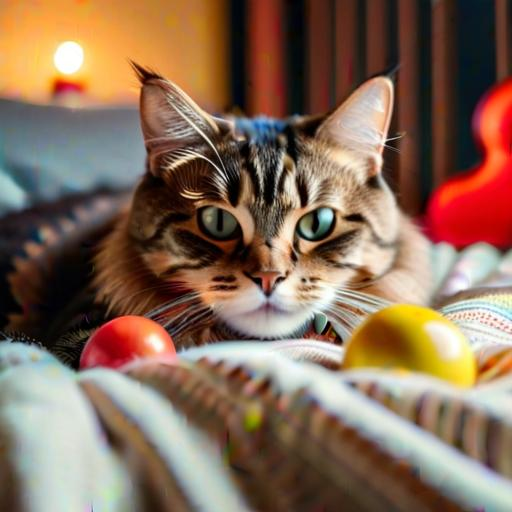

In [16]:
show_image_docs(result)

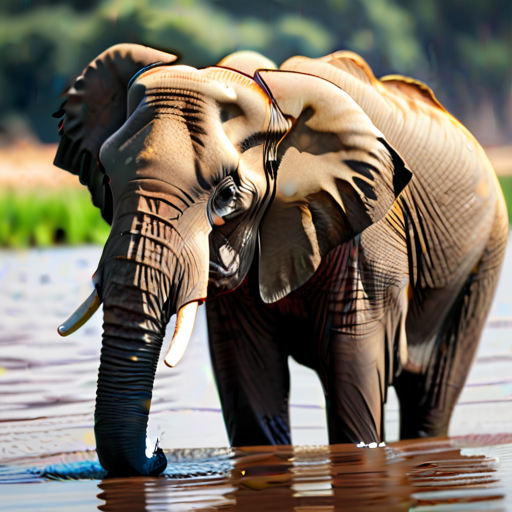

In [23]:
images[5]

In [ ]:
result = cdmm.search_image(image_or_text=images[5])

Rank[1]
Category: elephant
Prompt: an elephant standing in tall grass, golden sunlight illuminating its skin, highly detailed, ultra-realistic, 8k resolution.
Cosine Similarity Score: 0.923


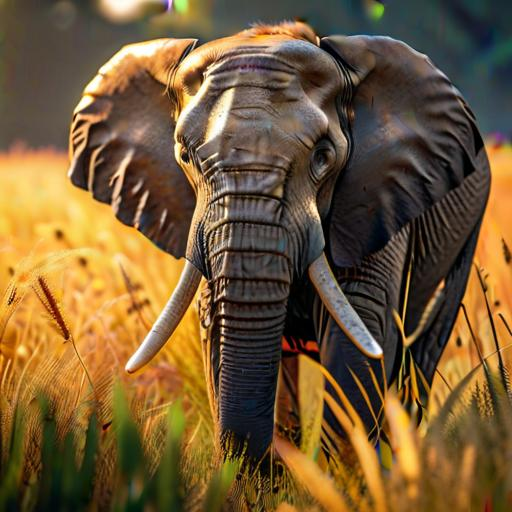

In [25]:
show_image_docs(result)

### Delete

The `delete` method removes documents from the vector database based on specified criteria.

- `ids` : A list of document IDs to be deleted. If None, all documents delete.

- `filters` : A dictionary specifying filtering criteria for deletion. This can include metadata filters( `where` , `where_document` ).

- `**kwargs` : Additional keyword arguments for custom deletion options.

In [26]:
len(cdmm.collection.get()["ids"])

2

In [27]:
ids = cdmm.collection.get()["ids"][:20]
cdmm.delete(ids=ids)
len(cdmm.collection.get()["ids"])

0

Remove a `Huggingface Cache` .

In [28]:
dataset.cleanup_cache_files()

7

Remove `Chroma Client` , `Embedding` .

In [29]:
del cdmm
del client
del multimodal_embedding